In [1]:
pip install scikit-learn scipy matplotlib seaborn joblib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
df = pd.read_csv("ai4i2020_cleaned.csv")   # from your preprocessing notebook
X = df.drop(columns=["Machine failure"])
y = df["Machine failure"]


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cat_cols = ["Type"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer([
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_cols)
])


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pipe_lr = Pipeline([("prep", preprocess),
                    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))])

pipe_rf = Pipeline([("prep", preprocess),
                    ("model", RandomForestClassifier(
                        n_estimators=300, class_weight="balanced",
                        random_state=42, n_jobs=-1))])

pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Type']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]',
                                                   'Temp diff [K]'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [6]:
from scipy.stats import randint, uniform

param_dist = {
    "model__n_estimators": randint(200, 900),
    "model__max_depth": randint(4, 40),
    "model__min_samples_split": randint(2, 12),
    "model__min_samples_leaf": randint(1, 6),
    "model__max_features": uniform(0.3, 0.7),   # fraction of features
}


In [7]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_base = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        class_weight="balanced",
        random_state=42, n_jobs=-1))
])

search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=40,                 # try 40 random combos
    scoring="roc_auc",         # good for imbalanced binary
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)
print("Best CV ROC-AUC:", search.best_score_)
print("Best Params:", search.best_params_)
best_model = search.best_estimator_     # this is a Pipeline(prep + RF)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV ROC-AUC: 0.9721681074298163
Best Params: {'model__max_depth': 39, 'model__max_features': np.float64(0.40000677254535855), 'model__min_samples_leaf': 3, 'model__min_samples_split': 7, 'model__n_estimators': 508}


Accuracy : 0.9835
Precision: 0.7611940298507462
Recall   : 0.75
F1       : 0.7555555555555555
ROC-AUC  : 0.9696025149190113


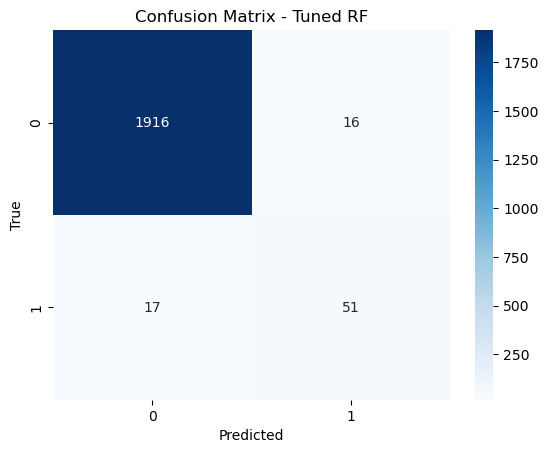

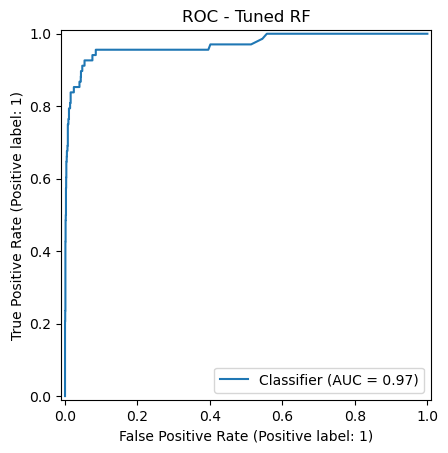

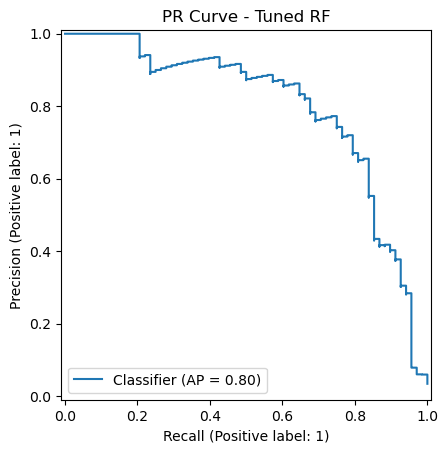

In [8]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             RocCurveDisplay, PrecisionRecallDisplay)
import matplotlib.pyplot as plt
import seaborn as sns

pred = best_model.predict(X_test)
proba = best_model.predict_proba(X_test)[:,1]

print("Accuracy :", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall   :", recall_score(y_test, pred))
print("F1       :", f1_score(y_test, pred))
print("ROC-AUC  :", roc_auc_score(y_test, proba))

# Confusion matrix
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Tuned RF")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ROC + PR curves
RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC - Tuned RF"); plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title("PR Curve - Tuned RF"); plt.show()


In [9]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

ths = np.linspace(0.05, 0.9, 18)
rows = []
for t in ths:
    p = (proba >= t).astype(int)
    rows.append({"threshold": t,
                 "precision": precision_score(y_test, p, zero_division=0),
                 "recall": recall_score(y_test, p, zero_division=0),
                 "f1": f1_score(y_test, p, zero_division=0)})
import pandas as pd
th_table = pd.DataFrame(rows)
th_table


,threshold,precision,recall,f1
0,0.05,0.223368,0.955882,0.362117
1,0.10,0.294931,0.941176,0.449123
2,0.15,0.357955,0.926471,0.516393
3,0.20,0.417808,0.897059,0.570093
4,0.25,0.479339,0.852941,0.613757
5,0.30,0.553398,0.838235,0.666667
6,0.35,0.640449,0.838235,0.726115
7,0.40,0.670732,0.808824,0.733333
8,0.45,0.716216,0.779412,0.746479
9,0.50,0.761194,0.750000,0.755556


In [10]:
import joblib, json
joblib.dump(best_model, "best_model_pipeline.joblib")
with open("decision_threshold.json", "w") as f:
    json.dump({"threshold": 0.30}, f)